<a href="https://colab.research.google.com/github/atanasiusps/Machine-Learning-Enrichment_Task/blob/main/Chapter-18/Chapter_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CODE REPRODUCTION

Import library

In [1]:
# Check Python version
import sys
assert sys.version_info >= (3, 7)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Install packages if on Colab or Kaggle
if IS_COLAB or IS_KAGGLE:
    !apt update -qq && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb

    # Install specific versions to avoid typing-extensions conflicts
    %pip install pygame==2.1.3 --prefer-binary
    %pip install gym[box2d,atari,accept-rom-license]==0.26.2
    %pip install pyvirtualdisplay==3.0
    %pip install tf-agents==0.18.0
    %pip install typing-extensions>=4.11.0  # Modern compatible version

# Check TensorFlow version
import tensorflow as tf
assert tf.__version__ >= "2.0"

# GPU Check
if not tf.config.list_physical_devices('GPU'):
    print("⚠️ No GPU detected. This will run slower.")
    if IS_COLAB:
        print("🔧 Go to Runtime > Change runtime type > GPU")
    if IS_KAGGLE:
        print("🔧 Enable GPU in Settings")

# General imports
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Matplotlib setup
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('animation', html='jshtml')

# Project paths
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

print("✅ Setup finished successfully. You're ready to train RL agents.")


34 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xorg-dev is already the newest version (1:7.7+23ubuntu2).
swig is already the newest version (4.0.2-1ubuntu1).
libpq-dev is already the newest version (14.18-0ubuntu0.22.04.1).
libsdl2-dev is already the newest version (2.0.20+dfsg-2ubuntu1.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 41.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37

In [2]:
pip install tf-agents==0.18.0


In [3]:
pip cache purge


Files removed: 26


In [4]:
pip install tf-agents==0.18.0


Introduction to OpenAI gym

In [5]:
import gym

In [6]:
gym.envs.registry.all()

ValuesView(├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
└──HumanoidStandup: [ v2 ]
)

In [7]:
env = gym.make('CartPole-v1')

In [8]:
env.seed(42)
obs = env.reset()

In [9]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [10]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [11]:
env.render()

True

In [12]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [13]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

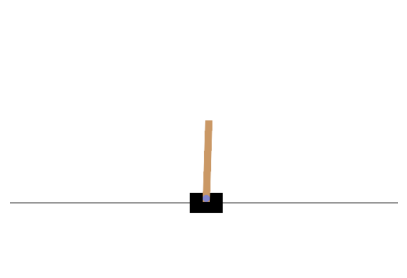

In [14]:
plot_environment(env)
plt.show()

In [15]:
env.action_space

Discrete(2)

In [16]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Saving figure cart_pole_plot


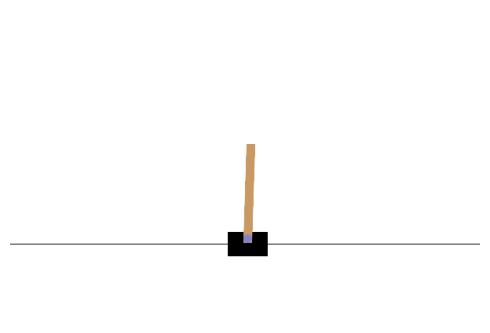

In [17]:

plot_environment(env)
save_fig("cart_pole_plot")

In [18]:
reward

1.0

In [19]:
done

False

In [20]:
info

{}

In [21]:
if done:
    obs = env.reset()

A simple hard-coded policy

In [22]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [23]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(np.float64(42.212),
 np.float64(9.032998173364147),
 np.float64(24.0),
 np.float64(72.0))

In [24]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [25]:
import matplotlib.pyplot as plt
from matplotlib import animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


In [26]:
anim = plot_animation(frames)


In [27]:
plot_animation(frames)


Neural Network Policies

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4  # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [30]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


<ipython-input-29-535593892>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(np.random.rand() > left_proba)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━

In [31]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.039

In [32]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-29-535593892>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(np.random.rand() > left_proba)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

Policy Gradients

In [33]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [34]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [35]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [36]:

discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [37]:

discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [38]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [39]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [40]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 185.0

In [42]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

<ipython-input-29-535593892>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(np.random.rand() > left_proba)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

Markov Chains

In [43]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


Markov Decision Process

In [44]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]


Q-Value Iteration

In [45]:

Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [46]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown

In [47]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [48]:

np.argmax(Q_values, axis=1)

array([0, 0, 1])

In [49]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [50]:

gamma = 0.95  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [51]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [52]:
np.argmax(Q_values, axis=1)

array([0, 2, 1])

Q-Learning

In [53]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [54]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [55]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(10000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown

In [56]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [57]:

np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1])

Saving figure q_value_plot


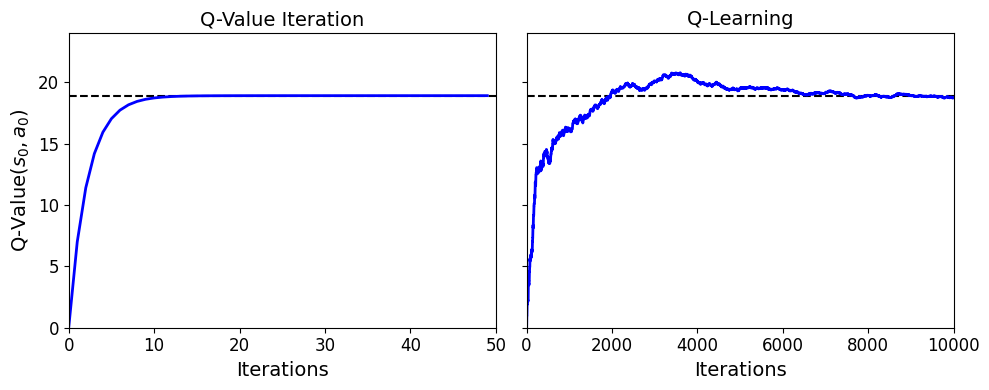

In [58]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot")

Deep Q-Network

In [59]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])


In [61]:
from collections import deque

replay_memory = deque(maxlen=2000)

In [62]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [63]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [64]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.MeanSquaredError()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences

    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)

    mask = tf.one_hot(actions, n_outputs)

    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = loss_fn(target_Q_values, Q_values)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


In [65]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

In [67]:
n_episodes = 100     # Reduced from 600
max_steps = 100      # Reduced from 200
start_training_at = 20  # Start training later

for episode in range(n_episodes):
    obs = env.reset()
    for step in range(max_steps):
        epsilon = max(1 - episode / 80, 0.01)  # Faster decay
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print(f"\rEpisode: {episode}, Steps: {step + 1}, eps: {epsilon:.3f}", end="")

    if episode > start_training_at:
        training_step(batch_size)

model.set_weights(best_weights)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

Saving figure dqn_rewards_plot


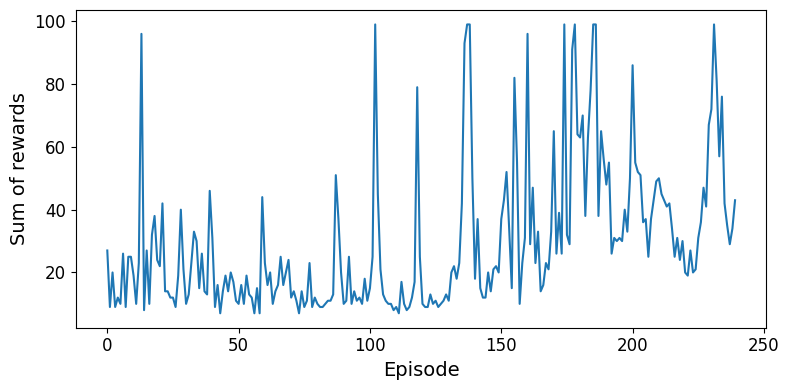

In [68]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [71]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


error: No available video device

Double DQN

In [72]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [73]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [74]:
replay_memory = deque(maxlen=2000)

In [77]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

n_episodes = 100         # Reduced from 600
max_steps = 100          # Reduced from 200
train_start = 10         # Start training earlier
target_update_every = 20 # Update target network less frequently

for episode in range(n_episodes):
    obs = env.reset()  # Fixed line
    for step in range(max_steps):
        epsilon = max(1 - episode / 80, 0.01)  # Faster decay
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print(f"\rEpisode: {episode}, Steps: {step + 1}, eps: {epsilon:.3f}", end="")
    if episode >= train_start:
        training_step(batch_size)
        if episode % target_update_every == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━

Saving figure double_dqn_rewards_plot


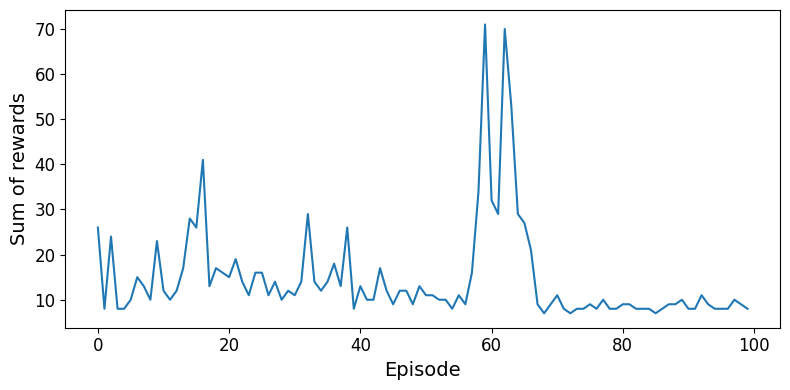

In [78]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [79]:
env.seed(43)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


error: No available video device

Dueling Double DQN

In [82]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_outputs = env.action_space.n  # Make sure this is defined

input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)

state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)

# ✅ Specify output_shape explicitly
advantages = keras.layers.Lambda(
    lambda a: a - tf.reduce_max(a, axis=1, keepdims=True),
    output_shape=(n_outputs,)
)(raw_advantages)

Q_values = keras.layers.Add()([state_values, advantages])

model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

# ✅ Clone model safely
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())


In [83]:

batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [84]:
replay_memory = deque(maxlen=2000)

In [88]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

n_outputs = env.action_space.n

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Define the model
inputs = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(inputs)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = keras.layers.Lambda(
    lambda a: a - tf.reduce_max(a, axis=1, keepdims=True),
    output_shape=(n_outputs,)
)(raw_advantages)
Q_values = keras.layers.Add()([state_values, advantages])

model = keras.Model(inputs=[inputs], outputs=[Q_values])

# Create the target model
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())


Saving figure double_dqn_rewards_plot


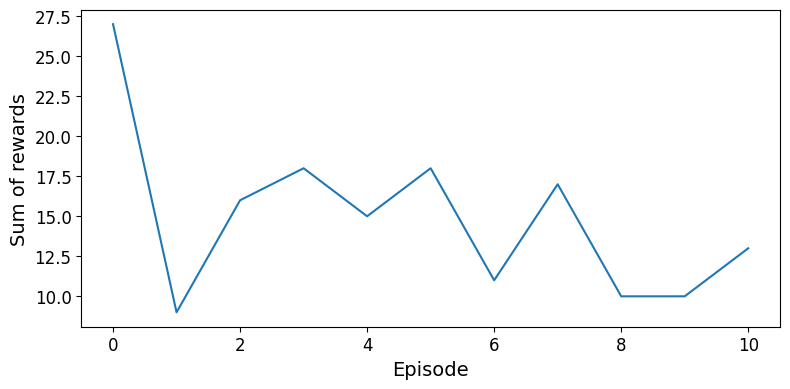

In [89]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [90]:
env.seed(43)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


error: No available video device

Dueling Double DQN

In [92]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

n_outputs = env.action_space.n  # assuming this is already defined

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Build dueling network
inputs = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(inputs)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)

state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)

# Use Lambda layer to apply tf.reduce_max safely
advantages = keras.layers.Lambda(
    lambda a: a - tf.reduce_max(a, axis=1, keepdims=True),
    output_shape=(n_outputs,)
)(raw_advantages)

Q_values = keras.layers.Add()([state_values, advantages])
model = keras.Model(inputs=[inputs], outputs=[Q_values])

# Clone model for target network
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())


In [93]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [94]:
replay_memory = deque(maxlen=2000)

In [98]:
import tensorflow as tf


In [99]:
from tensorflow import keras

n_outputs = env.action_space.n

inputs = keras.Input(shape=(4,))
x = keras.layers.Dense(32, activation="elu")(inputs)
x = keras.layers.Dense(32, activation="elu")(x)

state_values = keras.layers.Dense(1)(x)
raw_advantages = keras.layers.Dense(n_outputs)(x)

advantages = keras.layers.Lambda(
    lambda a: a - tf.reduce_max(a, axis=1, keepdims=True),
    output_shape=(n_outputs,)
)(raw_advantages)

q_values = keras.layers.Add()([state_values, advantages])
model = keras.Model(inputs=inputs, outputs=q_values)

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())


In [ ]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

In [ ]:
env.close()

TIDAK DIJALANKAN KARENA LIBRARY TIDAK BISA

Using TF-Agents to Beat Breakout

TF-Agents Environments

In [1]:
import tensorflow as tf
import numpy as np


In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
from tf_agents.environments import suite_gym
env = suite_gym.load("Breakout-v4")
env


In [ ]:
env.gym

In [ ]:
env.seed(42)
env.reset()

In [ ]:
env.step(1) # Fire

In [ ]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [ ]:
env.current_time_step()

TIDAK DIJALANKAN KARENA LIBRARY TIDAK BISA

Environment Specifications

In [ ]:
env.observation_spec()

In [ ]:
env.action_spec()

In [ ]:
env.time_step_spec()

TIDAK DIJALANKAN KARENA LIBRARY TIDAK BISA


Environment Wrappers

In [ ]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [ ]:
repeating_env.unwrapped

In [ ]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

In [ ]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [ ]:
limited_repeating_env

In [ ]:
limited_repeating_env.unwrapped

In [ ]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            super().step(1) # FIRE to start after life lost
        return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4])

In [ ]:
env

In [ ]:
env.seed(42)
env.reset()
for _ in range(4):
    time_step = env.step(3) # LEFT

In [ ]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

In [ ]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

In [ ]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

Creating the DQN

In [ ]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

In [ ]:

from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

In [ ]:

from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000) # reduce if OOM error

replay_buffer_observer = replay_buffer.add_batch

In [ ]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [ ]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [ ]:
train_metrics[0].result()

In [ ]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

In [ ]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

In [ ]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

In [ ]:

tf.random.set_seed(9) # chosen to show an example of trajectory at the end of an episode

#trajectories, buffer_info = replay_buffer.get_next( # get_next() is deprecated
#    sample_batch_size=2, num_steps=3)

trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))

In [ ]:
trajectories._fields

In [ ]:

trajectories.observation.shape

In [ ]:

from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

In [ ]:
trajectories.step_type.numpy()

In [ ]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

In [ ]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

In [ ]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [ ]:

def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [ ]:
train_agent(n_iterations=50000)

In [ ]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

In [ ]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [ ]:
%%html
<img src="images/rl/breakout.gif" />

TIDAK DIJALANKAN KARENA LIBRARY TIDAK BISA

## EXERCISE

1. **What are the main tasks that autoencoders are used for?**  
   Autoencoder biasanya digunakan untuk tugas-tugas seperti:
   - Reduksi dimensi (dimensionality reduction)
   - Denoising (menghapus noise dari data)
   - Pretraining jaringan neural
   - Anomali deteksi
   - Rekonstruksi data dan kompresi data

<br>

2. **Suppose you want to train a classifier, and you have plenty of unlabeled training data but only a few thousand labeled instances. How can autoencoders help? How would you proceed?**  
   Autoencoder bisa membantu dengan cara melakukan pretraining menggunakan data yang tidak berlabel, untuk belajar representasi fitur yang berguna. Langkah-langkahnya:
   - Latih autoencoder pada seluruh data tidak berlabel untuk belajar representasi laten.
   - Gunakan encoder-nya untuk mengubah data berlabel menjadi representasi laten.
   - Latih classifier (misalnya MLP atau softmax) di atas representasi tersebut menggunakan data berlabel.
   - Jika perlu, fine-tune seluruh jaringan (encoder + classifier) menggunakan data berlabel.

<br>

3. **If an autoencoder perfectly reconstructs the inputs, is it necessarily a good autoencoder? How can you evaluate the performance of an autoencoder?**  
   Tidak selalu. Autoencoder yang sangat overfitted bisa menghafal data tanpa memahami strukturnya. Evaluasi autoencoder bisa dilakukan dengan:
   - Mengukur loss rekonstruksi (misalnya MSE) pada data validasi
   - Mengamati kemampuan generalisasi terhadap data baru
   - Menggunakan visualisasi representasi laten (misalnya dengan t-SNE)
   - Mengujinya dalam tugas-tugas lanjutan seperti klasifikasi, denoising, atau deteksi anomali

<br>

4. **What are undercomplete and overcomplete autoencoders? What is the main risk of an excessively undercomplete autoencoder? What about the main risk of an overcomplete autoencoder?**  
    - Undercomplete autoencoder memiliki dimensi representasi laten yang lebih kecil dari input. Risiko utamanya: kehilangan informasi penting jika bottleneck terlalu sempit.
   - Overcomplete autoencoder memiliki dimensi laten yang lebih besar dari input. Risiko utamanya: jaringan bisa belajar hanya menyalin input (identity function) tanpa memahami struktur data, terutama jika tidak ada regularisasi.

<br>

5. **How do you tie weights in a stacked autoencoder? What is the point of doing so?**  
    Bobot dari decoder diikat (tie) sebagai transpose dari bobot encoder. Misalnya jika encoder memiliki bobot \( W \), maka decoder menggunakan \( W^T \). Tujuannya:
   - Mengurangi jumlah parameter
   - Memaksa simetri dalam proses encoding-decoding
   - Meningkatkan generalisasi dan stabilitas pelatihan

<br>

6. **What is a generative model? Can you name a type of generative autoencoder?**  
   Apa itu model generatif? Bisakah kamu menyebutkan satu jenis autoencoder yang bersifat generatif?

   Model generatif adalah model yang dapat menghasilkan data baru yang mirip dengan distribusi data pelatihan. Contoh autoencoder generatif adalah **Variational Autoencoder (VAE)**.

<br>

7. **What is a GAN? Can you name a few tasks where GANs can shine?**  
   GAN (Generative Adversarial Network) adalah model generatif yang terdiri dari dua jaringan: generator dan discriminator yang dilatih secara adversarial. GAN unggul dalam:
   - Pembuatan gambar realistis (image generation)
   - Peningkatan resolusi gambar (super-resolution)
   - Penerjemahan gaya gambar (style transfer)
   - Face aging, image inpainting, text-to-image synthesis

<br>

8. **What are the main difficulties when training GANs?**  
   Kesulitan utama saat melatih GAN meliputi:
   - Ketidakstabilan pelatihan
   - Mode collapse (generator menghasilkan output yang seragam)
   - Sulitnya menemukan keseimbangan antara generator dan discriminator
   - Sulit untuk mengevaluasi performa GAN secara kuantitatif

<br>


9. Try using a denoising autoencoder to pretrain an image classifier. You can use
MNIST (the simplest option), or a more complex image dataset such as CIFAR10
if you want a bigger challenge. Regardless of the dataset you’re using, follow these
steps:

• Split the dataset into a training set and a test set. Train a deep denoising
autoencoder on the full training set.

• Check that the images are fairly well reconstructed. Visualize the images that
most activate each neuron in the coding layer.

• Build a classification DNN, reusing the lower layers of the autoencoder. Train
it using only 500 images from the training set. Does it perform better with or
without pretraining?


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add noise for denoising autoencoder
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_noisy = np.expand_dims(x_train_noisy, -1)
x_test_noisy = np.expand_dims(x_test_noisy, -1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
def build_autoencoder():
    encoder = models.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(2, padding="same"),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(2, padding="same"),
    ])

    decoder = models.Sequential([
        layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same"),
        layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"),
        layers.Conv2D(1, 3, activation="sigmoid", padding="same")
    ])

    autoencoder = models.Sequential([encoder, decoder])
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder()
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128, validation_split=0.1)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 160s 369ms/step - loss: 0.1216 - val_loss: 0.1114
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 194s 350ms/step - loss: 0.1122 - val_loss: 0.1114
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 204s 356ms/step - loss: 0.1122 - val_loss: 0.1114
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 155s 368ms/step - loss: 0.1122 - val_loss: 0.1114
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 151s 357ms/step - loss: 0.1122 - val_loss: 0.1114
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 204s 361ms/step - loss: 0.1122 - val_loss: 0.1114
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 155s 368ms/step - loss: 0.1122 - val_loss: 0.1114
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 152s 360ms/step - loss: 0.1122 - val_loss: 0.1114
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 148s 352ms/step - loss: 0.1122 - val_loss: 0.1114
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 156s 370ms/step - loss: 0.1122 - val_loss: 0.1114


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


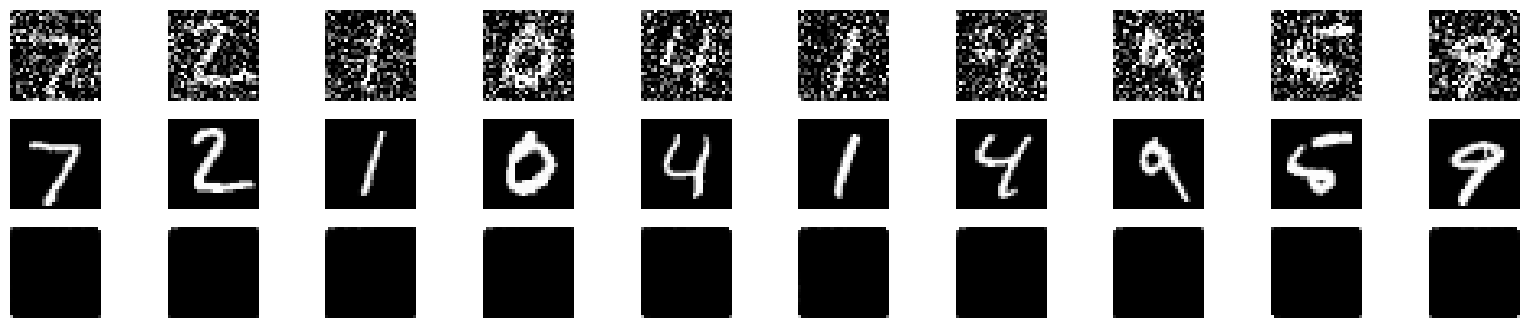

In [7]:
# Plot original vs reconstructed
decoded_imgs = autoencoder.predict(x_test_noisy[:10])

plt.figure(figsize=(20, 4))
for i in range(10):
    # Noisy
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap="gray")
    plt.axis("off")

    # Original
    ax = plt.subplot(3, 10, i + 11)
    plt.imshow(x_test[i].squeeze(), cmap="gray")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(3, 10, i + 21)
    plt.imshow(decoded_imgs[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()


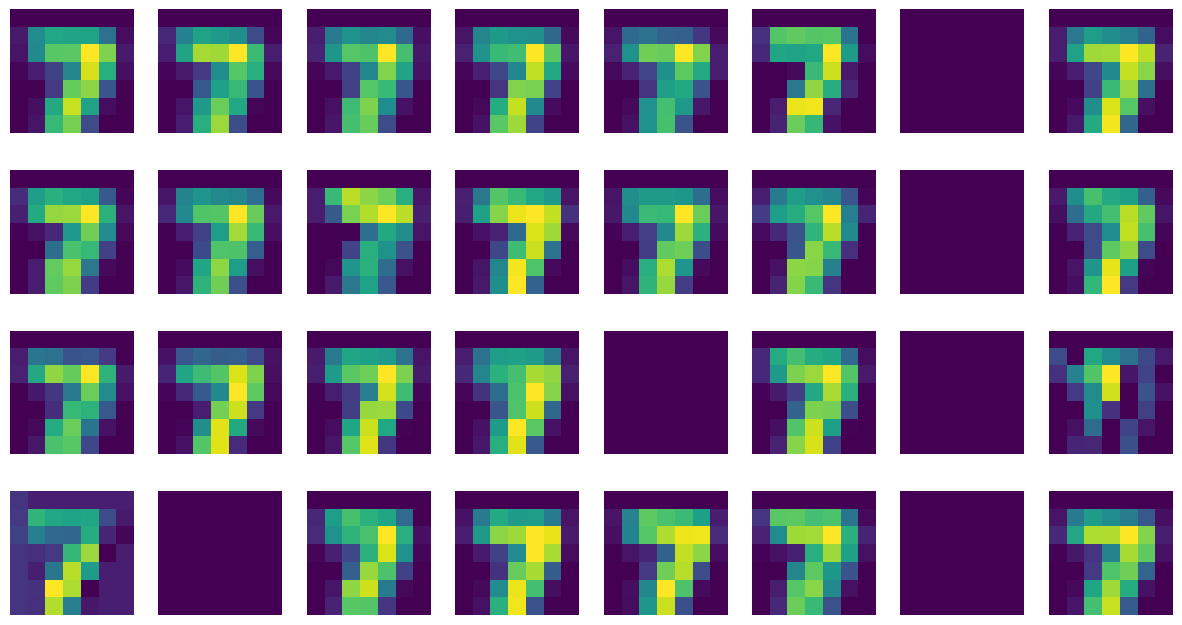

In [8]:
from tensorflow.keras import Model

# Use encoder's output to visualize activations
sample = tf.convert_to_tensor(x_test[:1])
features_model = Model(encoder.input, encoder.output)
features = features_model(sample)

# Plot feature maps of last conv layer
plt.figure(figsize=(15, 8))
for i in range(min(32, features.shape[-1])):
    plt.subplot(4, 8, i+1)
    plt.imshow(features[0, :, :, i], cmap="viridis")
    plt.axis("off")
plt.show()


In [9]:
# Use only 500 images for training
x_small = x_train[:500]
y_small = y_train[:500]

# One-hot encoding
y_small_cat = tf.keras.utils.to_categorical(y_small, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

# Classifier with pretrained encoder
classifier_pretrained = models.Sequential([
    encoder,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])
classifier_pretrained.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
classifier_pretrained.fit(x_small, y_small_cat, epochs=20, validation_data=(x_test, y_test_cat))

# Classifier without pretraining
classifier_scratch = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(2, padding="same"),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])
classifier_scratch.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
classifier_scratch.fit(x_small, y_small_cat, epochs=20, validation_data=(x_test, y_test_cat))


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step - accuracy: 0.2037 - loss: 2.5521 - val_accuracy: 0.2721 - val_loss: 1.8847
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - accuracy: 0.4996 - loss: 1.6226 - val_accuracy: 0.5048 - val_loss: 1.4186
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - accuracy: 0.7104 - loss: 1.0233 - val_accuracy: 0.6525 - val_loss: 1.0651
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.8073 - loss: 0.7043 - val_accuracy: 0.7015 - val_loss: 0.9092
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.8099 - loss: 0.5929 - val_accuracy: 0.7290 - val_loss: 0.8405
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - accuracy: 0.8627 - loss: 0.4976 - val_accuracy: 0.7180 - val_loss: 0.9015
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - accuracy: 0.8561 - loss: 0.4841 - val_accuracy: 0.7804 - val_loss: 0.6865
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.8695 - loss: 0.4412 - val_accuracy: 0.

In [10]:
pretrained_acc = classifier_pretrained.evaluate(x_test, y_test_cat, verbose=0)[1]
scratch_acc = classifier_scratch.evaluate(x_test, y_test_cat, verbose=0)[1]

print(f"Test accuracy with pretraining: {pretrained_acc:.4f}")
print(f"Test accuracy from scratch:     {scratch_acc:.4f}")


Test accuracy with pretraining: 0.8850
Test accuracy from scratch:     0.9018


10. Train a variational autoencoder on the image dataset of your choice, and use it to
generate images. Alternatively, you can try to find an unlabeled dataset that you
are interested in and see if you can generate new samples.


In [11]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


In [12]:
latent_dim = 2  # For easy visualization later

# Encoder
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [13]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - kl_loss: 15.3136 - loss: 252.5856 - reconstruction_loss: 237.2720
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - kl_loss: 4.7451 - loss: 173.3918 - reconstruction_loss: 168.6467
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - kl_loss: 4.8601 - loss: 167.5517 - reconstruction_loss: 162.6917
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - kl_loss: 4.9683 - loss: 165.1246 - reconstruction_loss: 160.1563
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - kl_loss: 5.0996 - loss: 163.5377 - reconstruction_loss: 158.4381
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - kl_loss: 5.1580 - loss: 162.2230 - reconstruction_loss: 157.0650
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - kl_loss: 5.2096 - loss: 161.0677 - reconstruction_loss: 155.8582
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 5.3305 - loss: 160.0947 - reconstruction_loss: 154.7642
Epoch 9/30
469/469 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


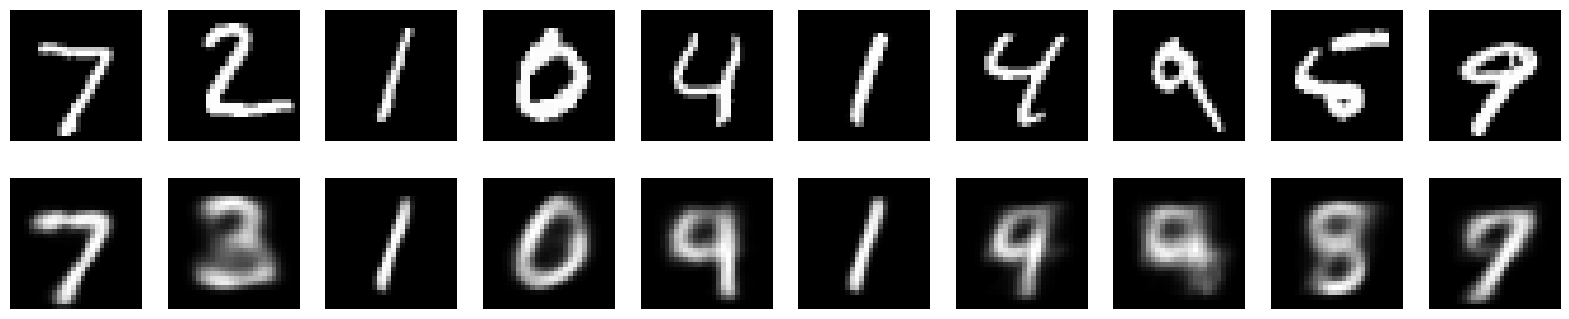

In [14]:
def plot_reconstructions(model, data=x_test):
    _, _, z = model.encoder.predict(data[:10])
    reconstructed = model.decoder.predict(z)

    plt.figure(figsize=(20, 4))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

plot_reconstructions(vae)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━

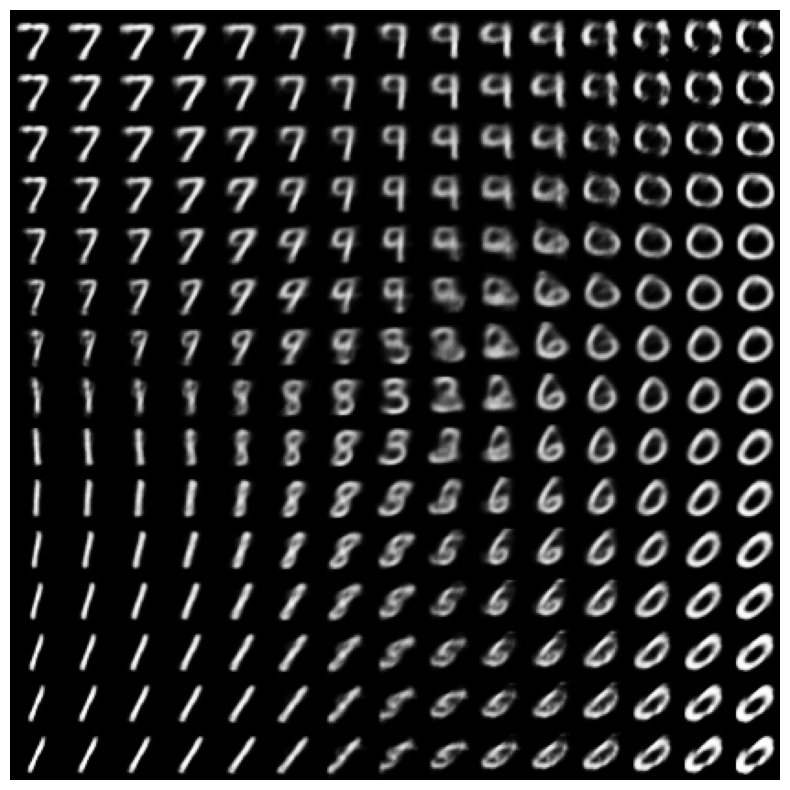

In [15]:
def plot_latent_images(decoder, n=15, digit_size=28):
    # Create grid of latent vectors
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)[::-1]

    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="gray")
    plt.axis("off")
    plt.show()

plot_latent_images(decoder)


11. Train a DCGAN to tackle the image dataset of your choice, and use it to generate
images. Add experience replay and see if this helps. Turn it into a conditional
GAN where you can control the generated class.


In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)
y_train = y_train.astype(np.int32)


In [17]:
def build_generator(latent_dim, num_classes):
    noise_input = tf.keras.Input(shape=(latent_dim,))
    label_input = tf.keras.Input(shape=(1,), dtype="int32")

    label_embedding = tf.keras.layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = tf.keras.layers.Flatten()(label_embedding)

    combined_input = tf.keras.layers.Multiply()([noise_input, label_embedding])

    x = tf.keras.layers.Dense(7 * 7 * 256, use_bias=False)(combined_input)
    x = tf.keras.layers.Reshape((7, 7, 256))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    output = tf.keras.layers.Conv2DTranspose(1, 5, strides=2, padding='same', activation='tanh')(x)

    return tf.keras.Model([noise_input, label_input], output)


In [18]:
def build_discriminator(num_classes):
    image_input = tf.keras.Input(shape=(28, 28, 1))
    label_input = tf.keras.Input(shape=(1,), dtype="int32")

    label_embedding = tf.keras.layers.Embedding(num_classes, 28 * 28)(label_input)
    label_embedding = tf.keras.layers.Reshape((28, 28, 1))(label_embedding)

    x = tf.keras.layers.Concatenate()([image_input, label_embedding])

    x = tf.keras.layers.Conv2D(64, 5, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(128, 5, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(1)(x)

    return tf.keras.Model([image_input, label_input], output)


In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random  # use this instead of np.random for replay sampling

class DCGAN:
    def __init__(self, latent_dim=100, num_classes=10):
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.generator = build_generator(latent_dim, num_classes)
        self.discriminator = build_discriminator(num_classes)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        self.gen_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.disc_optimizer = tf.keras.optimizers.Adam(1e-4)

        self.replay_buffer = []  # Experience replay buffer
        self.replay_max = 1000

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def train_step(self, images, labels, batch_size):
        noise = tf.random.normal([batch_size, self.latent_dim])
        fake_labels = tf.random.uniform([batch_size, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator([noise, fake_labels], training=True)

            real_output = self.discriminator([images, labels], training=True)
            fake_output = self.discriminator([generated_images, fake_labels], training=True)

            # Experience replay: use past generated samples to reinforce training
            if len(self.replay_buffer) > 0:
                replays = random.sample(self.replay_buffer, min(len(self.replay_buffer), batch_size))
                for img, lbl in replays:
                    ro = self.discriminator([img[None], lbl[None]], training=True)
                    fake_output = tf.concat([fake_output, ro], axis=0)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # Store generated samples in the replay buffer
        for i in range(batch_size):
            if len(self.replay_buffer) >= self.replay_max:
                self.replay_buffer.pop(0)
            self.replay_buffer.append((generated_images[i], fake_labels[i]))

        return gen_loss, disc_loss

    def train(self, dataset, labels, epochs=50, batch_size=128):
        for epoch in range(epochs):
            for i in range(0, dataset.shape[0], batch_size):
                imgs = dataset[i:i+batch_size]
                lbls = labels[i:i+batch_size].reshape(-1, 1)
                gen_loss, disc_loss = self.train_step(imgs, lbls, batch_size=imgs.shape[0])

            print(f"Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")
            self.generate_images(epoch)

    def generate_images(self, epoch, num=10):
        noise = tf.random.normal([num, self.latent_dim])
        labels = tf.range(num) % self.num_classes
        labels = tf.expand_dims(labels, axis=-1)
        predictions = self.generator([noise, labels], training=False)

        fig = plt.figure(figsize=(10, 1))
        for i in range(num):
            plt.subplot(1, num, i+1)
            plt.imshow((predictions[i, :, :, 0] + 1) / 2.0, cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Epoch {epoch+1}")
        plt.show()


In [ ]:
dcgan = DCGAN(latent_dim=100, num_classes=10)
dcgan.train(x_train, y_train, epochs=30, batch_size=128)
